In [1]:
import numpy as np
import ufl

from mpi4py import MPI
from petsc4py.PETSc import ScalarType

from dolfinx import mesh, fem, plot, io
from dolfinx.io import XDMFFile, gmshio
import dolfinx.geometry as geo
import gmsh

import pyvista

Defining the phisical properties of fibres

In [2]:
ν = 0.3
E = 2.1e10

λ = ν*E/(1+ν)/(1-2*ν)
μ = E/2/(1+ν)

ORDER = 2

unit_disp = 2.;

In [3]:
## Setting up gmsh properties
gmsh.initialize()

# Choose if Gmsh output is verbose
gmsh.option.setNumber("General.Terminal", 0)

# Set elements order to the specified one
gmsh.option.setNumber("Mesh.ElementOrder", ORDER)
# Set elements size
# gmsh.option.setNumber("Mesh.MeshSizeFromCurvature", 5) # uncomment to use for mesh refinement dependending from its surface curvature
gmsh.option.setNumber("Mesh.MeshSizeMax", 5e-2)
gmsh.option.setNumber("Mesh.MeshSizeMin", 1e-2)

# Set threads number for distrebuted meshing
# gmsh.option.setNumber("Mesh.MaxNumThreads3D", 4)

# Set mesh algorithm (default is Delaunay triangulation)
# see https://gmsh.info/doc/texinfo/gmsh.html#Choosing-the-right-unstructured-algorithm
gmsh.option.setNumber("Mesh.Algorithm3D", 3)

# gmsh.option.setNumber("Mesh.RecombinationAlgorithm",3)
# gmsh.option.setNumber("Mesh.Recombine3DAll",1)

# Set the usage of hexahedron elements 
gmsh.option.setNumber("Mesh.SubdivisionAlgorithm", 0)
## Importing RVE geometry
gmsh.open("in/test_rve(tet10)_1.msh")

model = gmsh.model()
# model.add("main_domain")
model_name = model.getCurrent()
tags = [dimtag[1] for dimtag in model.get_entities(3)]

model.add_physical_group(dim=3, tags=tags)


# Synchronize OpenCascade representation with gmsh model
model.occ.synchronize()


# Generate the mesh
# model.mesh.generate(2)
# model.mesh.recombine()
model.mesh.generate(dim=3)

bbox = [np.Inf,
        np.Inf,
        np.Inf,
        -np.Inf,
        -np.Inf,
        -np.Inf]
for tag in tags:
    buf_bbox = model.get_bounding_box(3, tag)
    for i in range(3):
        if bbox[i] > buf_bbox[i]:
            bbox[i] = buf_bbox[i]
    for j in range(3,6):
        if bbox[j] < buf_bbox[j]:
            bbox[j] = buf_bbox[j]
            
            
# Create a DOLFINx mesh (same mesh on each rank)
msh, cell_markers, facet_markers = gmshio.model_to_mesh(model, MPI.COMM_SELF,0)
msh.name = "Box"
cell_markers.name = f"{msh.name}_cells"
facet_markers.name = f"{msh.name}_facets"

# Finalize gmsh to be able to use it again
gmsh.finalize()


with io.XDMFFile(msh.comm, "out/imported_mesh.xdmf", "w") as file:
    file.write_mesh(msh)
    file.write_meshtags(cell_markers)
    msh.topology.create_connectivity(msh.topology.dim - 1, msh.topology.dim)
    file.write_meshtags(facet_markers)

In [4]:
def epsilon(u):
    return ufl.sym(ufl.grad(u)) # Equivalent to 0.5*(ufl.nabla_grad(u) + ufl.nabla_grad(u).T)
def sigma(u):
    return λ * ufl.nabla_div(u) * ufl.Identity(len(u)) + 2*μ*epsilon(u)


V = fem.VectorFunctionSpace(msh, ("CG", ORDER))
u = ufl.TrialFunction(V)
v = ufl.TestFunction(V)
f = fem.Constant(msh, ScalarType((0., 0., 0.)))
a = ufl.inner(sigma(u), epsilon(v)) * ufl.dx
L = ufl.dot(f, v) * ufl.dx #+ ufl.dot(T, v) * ds

Marking nodes on each side of the RVE by following:
- left (x = -1) - 1;
- right (x = 1) - 2;
- bottom (z = -1) - 3;
- top (z = 1) - 4;
- front (y = -1) - 5;
- back (y = 1) - 6;

In [5]:
eps = np.linalg.norm(np.array(bbox[0:3]) + np.array(bbox[3:]));

In [6]:
def left(x):
    return np.isclose(x[0], bbox[0], atol = eps);

def right(x):
    return np.isclose(x[0], bbox[3], atol = eps);

def bottom(x):
    return np.isclose(x[2], bbox[2], atol = eps);

def top(x):
    return np.isclose(x[2], bbox[5], atol = eps);

def front(x):
    return np.isclose(x[1], bbox[1], atol = eps);

def back(x):
    return np.isclose(x[1], bbox[4], atol = eps);

fdim = msh.topology.dim - 1

# find all facets on top, bottom and left boundary
left_facets = mesh.locate_entities_boundary(msh, fdim, left);
right_facets = mesh.locate_entities_boundary(msh, fdim, right);
bottom_facets = mesh.locate_entities_boundary(msh, fdim, bottom);
top_facets = mesh.locate_entities_boundary(msh, fdim, top);
front_facets = mesh.locate_entities_boundary(msh, fdim, front);
back_facets = mesh.locate_entities_boundary(msh, fdim, back);

In [7]:
marked_facets = np.hstack([left_facets, 
                           right_facets, 
                           bottom_facets,
                           top_facets,
                           front_facets,
                           back_facets,
                          ]);

markers = np.hstack([np.full_like(left_facets, 1),
                     np.full_like(right_facets, 2),
                     np.full_like(bottom_facets, 3),
                     np.full_like(top_facets, 4),
                     np.full_like(front_facets, 5),
                     np.full_like(back_facets, 6),
                    ]);

facets_order = np.argsort(marked_facets);

facets_tags = mesh.meshtags(msh, 
                            fdim, 
                            marked_facets[facets_order],
                            markers[facets_order]);

ds = ufl.Measure('ds', domain=msh, subdomain_data=facets_tags);


In [8]:
def KUBC(x, i, j, ud):
    values = np.zeros(x.shape);
    
    values[i,:] += 0.5*ud*(x[j])/(bbox[j+3] - bbox[j]);
    values[j,:] += 0.5*ud*(x[i])/(bbox[i+3] - bbox[i]);

    return values;
        

In [9]:
def macro_strain(i):
    """returns the macroscopic strain for the 3 elementary load cases"""
    ϵ = np.zeros((6,), dtype = np.float64)
    ϵ[i] = 1;
    ϵ[3:] /= 2;
    return np.array([[ϵ[0], ϵ[5], ϵ[4]],
                     [ϵ[5], ϵ[1], ϵ[3]],
                     [ϵ[4], ϵ[3], ϵ[2]]]);
# ε = fem.Constant
def stress2Voigt(s):
    return ufl.as_vector([s[0,0], 
                          s[1,1], 
                          s[2,2],
                          s[1,2],
                          s[0,2],
                          s[0,1]])

def strein2Voigt(s):
    return ufl.as_vector([s[0,0], 
                          s[1,1], 
                          s[2,2],
                          2*s[1,2],
                          2*s[0,2],
                          2*s[0,1]])

def indexVoigt(i, j):
    if i==j:
        return i
    elif (i==0):
        if (j==1):
            return 5;
        else:
            return 4;
    else:
        return 3;



# Homogenization of elastic properties

For homogeinzation procedure we wil use the Voigt notation, according to which the stress and strein tensors are represented as a vectors:

$$
    \mathbf{\varepsilon} = 
    \left\{
        \begin{matrix}
            \varepsilon_{11} \\ 
            \varepsilon_{22} \\ 
            \varepsilon_{33} \\ 
            \varepsilon_{23} \\ 
            \varepsilon_{13} \\ 
            \varepsilon_{12} \\
        \end{matrix}
    \right\}
    = 
    \left\{
        \begin{matrix}
            \varepsilon_{x} \\ 
            \varepsilon_{y} \\ 
            \varepsilon_{z} \\ 
            \gamma_{yz}\\
            \gamma_{xz}\\
            \gamma_{xy}\\ 
        \end{matrix}
    \right\};\hspace{2cm}
    \mathbf{\sigma} = 
    \left\{
        \begin{matrix}
            \sigma_{11} \\ 
            \sigma_{22} \\ 
            \sigma_{33} \\ 
            \sigma_{23} \\ 
            \sigma_{13} \\ 
            \sigma_{12} \\
        \end{matrix}
    \right\}
    = 
    \left\{
        \begin{matrix}
            \sigma_{x} \\ 
            \sigma_{y} \\ 
            \sigma_{z} \\ 
            \tau_{yz}\\
            \tau_{xz}\\
            \tau_{xy}\\ 
        \end{matrix}
    \right\};
$$
Then the stiffness can be determined as
$$
    \hat{\sigma} = \mathbf{\hat{C}}\hat{\varepsilon},
$$
where $\mathbf{\hat{C}}$ is averaged matrix of elastic properties, $ \hat{\varepsilon}~-$  an average strein within the RVEvolume, which is determined by the BC and $\hat{\sigma}~-$  an average stress within the RVE's volume, which is determined according to
$$
    \hat{\sigma} = \frac{1}{V}\int_\Omega{\sigma (x) dx}, 
$$
where V - RVE volume and $\Omega$ - RVE domain, so 
$$
    V = \int_\Omega{dx}, 
$$

To determine an avarage elastic properties of the material we need to solve 6 different  boundary problems:
$$
    \hat{\varepsilon}_{1} = 
    \left\{
        \begin{matrix} 1\\ 0\\ 0\\ 0\\ 0\\ 0\\ \end{matrix}
    \right\};\ 
    \hat{\varepsilon}_{2} = 
    \left\{
        \begin{matrix} 0\\ 1\\ 0\\ 0\\ 0\\ 0\\ \end{matrix}
    \right\};\ 
    \hat{\varepsilon}_{3} = 
    \left\{
        \begin{matrix} 0\\ 0\\ 1\\ 0\\ 0\\ 0\\ \end{matrix}
    \right\};\ 
    \hat{\varepsilon}_{4} = 
    \left\{
        \begin{matrix} 0\\ 0\\ 0\\ 1\\ 0\\ 0\\ \end{matrix}
    \right\};\ 
    \hat{\varepsilon}_{5} = 
    \left\{
        \begin{matrix} 0\\ 0\\ 0\\ 0\\ 1\\ 0\\ \end{matrix}
    \right\};\ 
    \hat{\varepsilon}_{6} = 
    \left\{
        \begin{matrix} 0\\ 0\\ 0\\ 0\\ 0\\ 1\\ \end{matrix}
    \right\};\
$$

in each case we obtain we obtain a certain value of Voigt stress vector. Full series of calculation will give us following SLE:

$$
    \begin{bmatrix}
        \hat{\sigma}_{x}^1 & \hat{\sigma}_{x}^2 & \hat{\sigma}_{x}^3 & \hat{\sigma}_{x}^4 & \hat{\sigma}_{x}^5 & \hat{\sigma}_{x}^6 \\
        \hat{\sigma}_{y}^1 & \hat{\sigma}_{y}^2 & \hat{\sigma}_{y}^3 & \hat{\sigma}_{y}^4 & \hat{\sigma}_{y}^5 & \hat{\sigma}_{y}^6 \\ 
        \hat{\sigma}_{z}^1 & \hat{\sigma}_{z}^2 & \hat{\sigma}_{z}^3 & \hat{\sigma}_{z}^4 & \hat{\sigma}_{z}^5 & \hat{\sigma}_{z}^6 \\ 
        \hat{\tau}_{yz}^1 & \hat{\tau}_{yz}^2 & \hat{\tau}_{yz}^3 & \hat{\tau}_{yz}^4 & \hat{\tau}_{yz}^5 & \hat{\tau}_{yz}^6 \\ 
        \hat{\tau}_{xz}^1 & \hat{\tau}_{xz}^2 & \hat{\tau}_{xz}^3 & \hat{\tau}_{xz}^4 & \hat{\tau}_{xz}^5 & \hat{\tau}_{xz}^6 \\
        \hat{\tau}_{xy}^1 & \hat{\tau}_{xy}^2 & \hat{\tau}_{xy}^3 & \hat{\tau}_{xy}^4 & \hat{\tau}_{xy}^5 & \hat{\tau}_{xy}^6 \\
    \end{bmatrix}
    =
    \mathbf{\hat{C}}
    \begin{bmatrix}
        1 & 0 & 0 & 0 & 0 & 0 \\
        0 & 1 & 0 & 0 & 0 & 0 \\
        0 & 0 & 1 & 0 & 0 & 0 \\
        0 & 0 & 0 & 1 & 0 & 0 \\
        0 & 0 & 0 & 0 & 1 & 0 \\
        0 & 0 & 0 & 0 & 0 & 1 \\
    \end{bmatrix}
$$
since Voigt strein matrix actualy is a unit matrix, then the avareged elastic matrix $\mathbf{\hat{C}}$ will be equal to the matrix of calulated stress 
$\begin{bmatrix} \hat{\sigma}^1 &\hat{\sigma}^2 & \hat{\sigma}^3 & \hat{\sigma}^4 & \hat{\sigma}^5 & \hat{\sigma}^6 \end{bmatrix}$

In [10]:
m_σ = np.zeros((6,6), dtype = np.float64);
m_ε = np.zeros((6,6), dtype = np.float64);

In [11]:
dx = ufl.Measure('dx', domain=msh);
volume = fem.assemble_scalar(fem.form(fem.Constant(msh, ScalarType(1.0)) * dx));
for i in range(3):
    for j in range(i,3):

        ub_ = fem.Function(V);
        full_bc = lambda x: KUBC(x, i,j, unit_disp);
        ub_.interpolate(full_bc);
        nonbottom_dofs = fem.locate_dofs_topological(V,
                                                 facets_tags.dim,
                                                 marked_facets);
        bc_ = fem.dirichletbc(ub_, nonbottom_dofs);
        problem = fem.petsc.LinearProblem(a, L, bcs=[bc_], petsc_options={"ksp_type": "preonly", "pc_type": "lu"})

        uh = problem.solve()
        for (k, case) in enumerate(["xx", "yy", "zz", "yz", "xz", "xy"]):
            ϵ_i = fem.assemble_scalar(fem.form(strein2Voigt(epsilon(uh))[k]*dx)) / volume;
            σ_i = fem.assemble_scalar(fem.form(stress2Voigt(sigma(uh))[k]*dx)) / volume;
            m_σ[indexVoigt(i, j), k] = σ_i;
            m_ε[indexVoigt(i, j), k] = ϵ_i;
            print("ε{} = {}; σ{} = {} ".format(case, ϵ_i, case, σ_i));


εxx = 0.5245035061680029; σxx = 13745587513.813013 
εyy = -0.08215958993506964; σyy = 3945645192.148142 
εzz = -0.007125494745372292; σzz = 5157734422.135531 
εyz = 0.022291711332230815; σyz = 180048437.68340194 
εxz = -0.07791824214207069; σxz = -629339648.0705653 
εxy = 0.020159504853293757; σxy = 162826769.9689095 
εxx = 0.003427037295031701; σxx = 162818220.1362468 
εyy = 0.007181176568471123; σyy = 223462008.39949805 
εzz = -0.0017386327218231964; σzz = 79372781.40243511 
εyz = -0.03191393517078356; σyz = -257766399.45632276 
εxz = 0.021497867557683938; σxz = 173636622.58129635 
εxy = 0.6115601399571399; σxy = 4939524207.346016 
εxx = -0.011515572253826954; σxx = -629288959.1152463 
εyy = 0.005318570981053152; σyy = -357352799.1671865 
εzz = -0.03039021329989044; σzz = -934187006.782416 
εyz = 0.0008161429162284283; σyz = 6591923.55415288 
εxz = 0.7379274426046882; σxz = 5960183190.268742 
εxy = 0.02150255564214303; σxy = 173674487.87884703 
εxx = -0.07626033516564204; σxx = 39374

In [12]:
np.set_printoptions(precision=2, suppress=True);
m_σ

array([[ 1.37e+10,  3.95e+09,  5.16e+09,  1.80e+08, -6.29e+08,  1.63e+08],
       [ 3.94e+09,  1.33e+10,  5.16e+09,  4.78e+08, -3.57e+08,  2.23e+08],
       [ 5.16e+09,  5.17e+09,  2.17e+10,  5.70e+08, -9.34e+08,  7.95e+07],
       [ 1.80e+08,  4.78e+08,  5.69e+08,  6.05e+09,  6.57e+06, -2.58e+08],
       [-6.29e+08, -3.57e+08, -9.34e+08,  6.59e+06,  5.96e+09,  1.74e+08],
       [ 1.63e+08,  2.23e+08,  7.94e+07, -2.58e+08,  1.74e+08,  4.94e+09]])

In [13]:
m_ε

array([[ 0.52, -0.08, -0.01,  0.02, -0.08,  0.02],
       [-0.08,  0.5 , -0.  ,  0.06, -0.04,  0.03],
       [-0.14, -0.14,  0.89,  0.07, -0.12,  0.01],
       [-0.01,  0.01,  0.02,  0.75,  0.  , -0.03],
       [-0.01,  0.01, -0.03,  0.  ,  0.74,  0.02],
       [ 0.  ,  0.01, -0.  , -0.03,  0.02,  0.61]])

In [14]:
np.savetxt("epsilon.txt", m_ε, delimiter = ", ")

In [15]:
import matplotlib.pyplot as plt

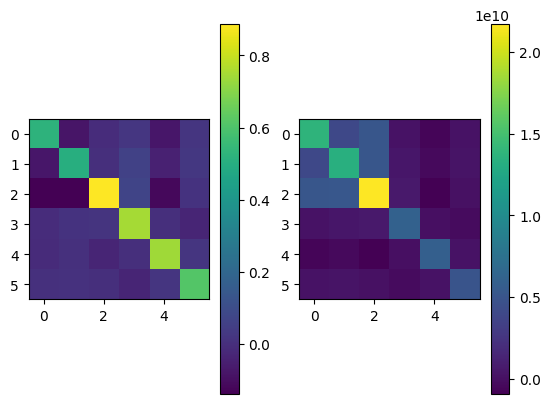

In [16]:
plt.subplot(121)
plt.imshow(m_ε)
plt.colorbar()
plt.subplot(122)
plt.imshow(m_σ)
plt.colorbar()


In [17]:
C = m_σ @ np.linalg.inv(m_ε)
C

array([[ 3.00e+10,  1.45e+10,  6.26e+09, -2.47e+09,  4.22e+09, -1.76e+09],
       [ 1.36e+10,  3.04e+10,  6.14e+09, -2.82e+09,  3.79e+09, -1.83e+09],
       [ 1.95e+10,  2.03e+10,  2.49e+10, -3.87e+09,  5.98e+09, -2.24e+09],
       [ 7.24e+08,  1.01e+09,  4.98e+08,  7.92e+09,  2.18e+08, -9.32e+07],
       [-1.42e+09, -1.25e+09, -8.06e+08,  2.23e+08,  7.72e+09,  1.41e+08],
       [ 3.49e+08,  4.17e+08,  1.12e+08, -5.56e+07,  8.06e+07,  8.04e+09]])

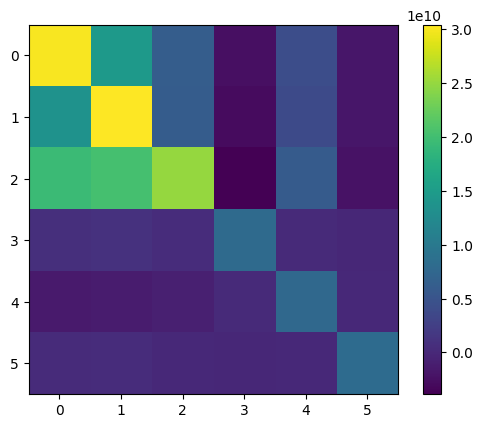

In [18]:
plt.imshow(C); plt.colorbar()